In [1]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown
from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from numpy import array
from sklearn.model_selection import KFold

nltk.download('brown')
nltk.download('universal_tagset')

total = len(brown.tagged_sents())
tags = 'universal'
train_size = int(total * 0.8)
test_size = total - train_size
sent = brown.tagged_sents(tagset = tags)[:]

w2v_words = Word2Vec(brown.sents(), size=30)

tags_list = list(set([tag for (_, tag) in brown.tagged_words(tagset=tags)]))
print(tags_list)
all_tags = ['DET','NOUN','ADP','ADJ','NUM','X','PRON','PRT','VERB','.','CONJ','ADV']

all_tags.append("<s>")
all_tags.append("</s>")

tags = {'ADJ':0,
 'CONJ':1,
 'NOUN':2,
 '.':3,
 'X':4,
 'NUM':5,
 'ADP':6,
 'VERB':7,
 'PRON':8,
 'DET':9,
 'PRT':10,
 'ADV':11,
 '<s>':12,
 '</s>':13}
# ////////////////////////////////////////////////

def onehot(n, l):
    oh = np.zeros(l)
    oh[n] = 1
    return oh

def features_svm(wid, sen, w2v,tags):
    ft = []
    keys = w2v.wv.vocab.keys()

    words_prev_n = 2
    for i in reversed(range(0,words_prev_n+1)):
        if sen[wid-i][0] not in keys:
            vec = np.zeros(w2v.vector_size)
            ft.append(vec)
        else:
            vec = w2v[sen[wid-i][0]]
            ft.append(vec)
        #print("--->1",w2v.vector_size)

    words_next_n = 2
    for i in range(1,words_next_n+1):
        if sen[wid+i][0] not in keys:
            vec = np.zeros(w2v.vector_size)
            ft.append(vec)
        else:
            vec = w2v[sen[wid+i][0]]
            ft.append(vec)
        #print("--->2",w2v.vector_size)
    tags_prev_n = 2
    for i in reversed(range(1,tags_prev_n+1)):
        tag = sen[wid-i][1]
        vec = onehot(tags.index(tag), len(tags))
        ft.append(vec)
        #print("--->3",OneHotEncoder(tags.index(tag),len(tags)).shape)

    if sen[wid][0][0].isupper():
        ft.append([1])
    else:
        ft.append([0])
    #print("---->4",(np.asarray(features).shape))

    if len(sen[wid][0]) > 4:
        if sen[wid][0][-4:].lower() == 'able' or sen[wid][0][-3:].lower() == 'ful' or sen[wid][0][-4:].lower() == 'less':
            ft.append([1])
        else: 
            ft.append([0])
    else:
        ft.append([0])

    if len(sen[wid][0]) > 5:
        if sen[wid][0][-4:].lower() in ["ship","ness","sion","ment"] or sen[wid][0][-3:].lower() in ["eer","ion","ity"] or sen[wid][0][-2:].lower() in ["er","or","th"]:
            ft.append([1])
        else: 
            ft.append([0])
    else:
        ft.append([0])

    if len(sen[wid][0]) > 5:
        if sen[wid][0][-4:].lower() in ["able","ible","less","ious"] or sen[wid][0][-3:].lower() in ["ant","ary","ful","ous","ive"] or sen[wid][0][-2:].lower() in ["al","ic"]:
            ft.append([1])
        else: 
            ft.append([0])
    else:
        ft.append([0])

    if len(sen[wid][0]) > 5:
        if sen[wid][0][-3:].lower() in ["ing","ize","ise"] or sen[wid][0][-2:].lower() in ["ed","en","er"]:
            ft.append([1])
        else: 
            ft.append([0])
    else:
        ft.append([0])

    if len(sen[wid][0]) > 5:
        if sen[wid][0][-4:].lower() in ["wise","ward"] or sen[wid][0][-2:].lower() in ["ly"]:
            ft.append([1])
        else: 
            ft.append([0])
    else:
        ft.append([0])
    



    if wid ==0:
      ft.append([1])
    else:
        ft.append([0])

    if wid == len(sen)-1:
        ft.append([1])
    else:
        ft.append([0])
      
    if sen[wid][0].upper() == sen[wid][0]:
        ft.append([1])
    else:
        ft.append([0])

    if sen[wid][0].lower() == sen[wid][0]:
        ft.append([1])
    else:
        ft.append([0])

    if '-' in sen[wid][0]:
      ft.append([1])
    else:
        ft.append([0])

    if sen[wid][0].isdigit():
      ft.append([1])
    else:
        ft.append([0])
    
    if sen[wid][0][1:].lower() != sen[wid][0][1:]:
      ft.append([1])
    else:
        ft.append([0])

    #print("---->5",(np.asarray(ft).shape))

    total_feature_list = []
    for sublist in ft:
        for item in sublist:
            total_feature_list.append(item)

        
    #print("---->6",(np.asarray(total_feature_list).shape))
    return total_feature_list


def vectorized_grad_loss(weights, x_train, y, reg):
    # print("------>")
    # dW = np.zeros(weight.shape)
    loss = 0.0
    delta = 1.0

    train_num = y.shape[0]
    current_label = weights.dot(x_train)
 
    actual_class = current_label[y, range(train_num)] 
    
    diff = current_label - actual_class + delta

    diff = np.maximum(0, diff)
    diff[y, range(train_num)] = 0

    loss = np.sum(diff) / train_num

    loss += 0.5 * reg * np.sum(weights * weights)

    current_label_grad = np.zeros(current_label.shape)

    pos_num = np.sum(diff > 0, axis=0)
    current_label_grad[diff > 0] = 1
    current_label_grad[y, range(train_num)] = -1 * pos_num

    dW = current_label_grad.dot(x_train.T) / train_num + reg * weights
    
    return loss, dW



class classifier:

    def __init__(self):
        self.weights = None 

    def train(self, X, y, gradients='sgd', lr=0.1,reg = 0, num_iters=1000, batch_size=128):
        
        dim, num_train = X.shape
        class_num = np.max(y) + 1
        
        # self.weights = np.random.normal(0,1, size=(class_num, dim))
        self.weights = np.random.randn(class_num, dim) * 0.001

        list_losses = []
        method='sgd'

        for i in range(num_iters):
            if method == 'bgd':
                loss, grad = self.loss_grad(X, y, reg, vectorized)
            else:
                idxs = np.random.choice(num_train, batch_size, replace=True)
                loss, grad = self.loss_grad(X[:, idxs], y[idxs], reg) 
            # loss, grad = self.loss_grad(X, y, reg)
            list_losses.append(loss)

            self.weights -= lr * grad
            
            if i % 100 == 0:
                print ('iteration %d/%d: loss %f' % (i, num_iters, loss) )

        return list_losses

    def predict(self, x_train):
        
        pred_val = self.weights.dot(x_train)
        # if self.__class__.__name__ == 'Logistic':
        #     y = f_x_mat.squeeze() >=0
        # else: 
        y = np.argmax(pred_val, axis=0)

        hx = 1.0 / (1.0 + np.exp(-pred_val))
        hx = hx.squeeze()
        return y, hx

class SVM(classifier):
    def loss_grad(self, X, y, reg):
        return vectorized_grad_loss(self.weights, X, y, reg)

# ////////////////////////////////////////////////

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
['ADJ', 'ADV', 'PRT', 'PRON', 'NUM', 'ADP', 'VERB', '.', 'DET', 'NOUN', 'X', 'CONJ']


In [2]:
# 5-FOLD DATA DIVISION
test_X_k,train_X_k=[],[]
kfold = KFold(5, True, 1)

for train,test in kfold.split(sent):
    print(train,test)
    sl=[]
    for i in train:
        sl.append(sent[i]) 
    train_X_k.append(sl)
    
    sl=[]
    for i in test:
        sl.append(sent[i])
    test_X_k.append(sl)
# print(train_X_k)
# //////////////////////////////////////////////////////////////
# test_set =  brown.tagged_sents(tagset = tags)[-test_size:]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 57337 57338 57339] [   10    12    28 ... 57305 57312 57332]
[    0     1     4 ... 57337 57338 57339] [    2     3     8 ... 57324 57334 57336]
[    1     2     3 ... 57336 57338 57339] [    0    21    22 ... 57333 57335 57337]
[    0     2     3 ... 57337 57338 57339] [    1     4     5 ... 57328 57330 57331]
[    0     1     2 ... 57335 57336 57337] [    9    14    15 ... 57329 57338 57339]


In [24]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
tags_plot = ['NOUN','NUM','CONJ','DET','VERB','PRT','ADV','PRON','ADP','ADJ','.','X']
tags = {'ADJ':0,
 'CONJ':1,
 'NOUN':2,
 '.':3,
 'X':4,
 'NUM':5,
 'ADP':6,
 'VERB':7,
 'PRON':8,
 'DET':9,
 'PRT':10,
 'ADV':11,
 '<s>':12,
 '</s>':13}
confusions=[]
c=1

for train_set,test_set in zip(train_X_k,test_X_k):
    print("++++++++++++\nStarting training",c,"of 5")
    c+=1
    x_text = []
    y_test = []
    for each_sent in tqdm(test_set):
        each_sent = [("","<s>") , ("","<s>")] + each_sent + [("","</s>"),  ("","</s>")]

        for j in range(2,len(each_sent)-2):
            x_text.append(features_svm(j, each_sent, w2v_words, all_tags))
            y_test.append(tags[each_sent[j][1]])


    fet_train = []
    y_train = []
    for each_sent in tqdm(train_set):
        each_sent = [("","<s>") , ("","<s>")] + each_sent + [("","</s>"), ("","</s>")]

        for j in range(2,len(each_sent)-2):
            fet_train.append(features_svm(j, each_sent, w2v_words, all_tags))
            y_train.append(tags[each_sent[j][1]])

    X_train=np.array(fet_train).astype(np.float)
    y_train=np.array(y_train)

    x_text=np.array(x_text).astype(np.float)
    y_test=np.array(y_test)

    x_text=np.transpose(x_text)

    y_train
    X_train=np.transpose(X_train)
    print(X_train.shape)

    print(x_text.shape)


    grad_svm = SVM()
    losses_sgd = grad_svm.train(X_train, y_train, lr=0.1,reg = 0, num_iters=10000, batch_size=256)
    y_train_pred_sgd = grad_svm.predict(X_train)[0]

    print(y_train_pred_sgd.shape,y_train_pred_sgd);
    print(y_train.shape,y_train)

    print ('Training accuracy: %f' % (np.mean(y_train == y_train_pred_sgd)) )
    y_val_pred_sgd = grad_svm.predict(x_text)[0]
    print ('test accuracy: %f' % (np.mean(y_test == y_val_pred_sgd)) )
    print(y_test)
    rtags = {0:'ADJ',1:'CONJ',2:'NOUN',3:'.',4:'X',5:'NUM',6:'ADP',7:'VERB',8:'PRON',9:'DET',10:'PRT',11:'ADV',12:'<s>',13:'</s>'}
    y_test_conf_matrix = [rtags[label] for label in y_test]
    y_val_pred_sgd_conf_matrix = [rtags[label] for label in y_val_pred_sgd]
    cm = confusion_matrix(y_test_conf_matrix, y_val_pred_sgd_conf_matrix, labels = tags_plot)
    cm=cm.astype('float')
    confusions.append(cm)

  0%|          | 0/11468 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:81: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  1%|          | 70/11468 [00:00<00:16, 682.20it/s]

++++++++++++
Starting training 1 of 5


100%|██████████| 45872/45872 [01:09<00:00, 658.94it/s] 


(191, 928761)
(191, 232431)
iteration 0/10000: loss 10.987121
iteration 100/10000: loss 0.671261
iteration 200/10000: loss 0.570375
iteration 300/10000: loss 0.541992
iteration 400/10000: loss 0.457484
iteration 500/10000: loss 0.338967
iteration 600/10000: loss 0.441406
iteration 700/10000: loss 0.400457
iteration 800/10000: loss 0.392884
iteration 900/10000: loss 0.414716
iteration 1000/10000: loss 0.410152
iteration 1100/10000: loss 0.376631
iteration 1200/10000: loss 0.378099
iteration 1300/10000: loss 0.227798
iteration 1400/10000: loss 0.338954
iteration 1500/10000: loss 0.322019
iteration 1600/10000: loss 0.237051
iteration 1700/10000: loss 0.360198
iteration 1800/10000: loss 0.535627
iteration 1900/10000: loss 0.409165
iteration 2000/10000: loss 0.379481
iteration 2100/10000: loss 0.483952
iteration 2200/10000: loss 0.363640
iteration 2300/10000: loss 0.415969
iteration 2400/10000: loss 0.375026
iteration 2500/10000: loss 0.364032
iteration 2600/10000: loss 0.360938
iteration 2

  1%|          | 81/11468 [00:00<00:14, 805.07it/s]

++++++++++++
Starting training 2 of 5


100%|██████████| 45872/45872 [01:08<00:00, 670.21it/s] 


(191, 929375)
(191, 231817)
iteration 0/10000: loss 11.006430
iteration 100/10000: loss 0.909125
iteration 200/10000: loss 0.609349
iteration 300/10000: loss 0.415156
iteration 400/10000: loss 0.418664
iteration 500/10000: loss 0.388975
iteration 600/10000: loss 0.473749
iteration 700/10000: loss 0.357172
iteration 800/10000: loss 0.382240
iteration 900/10000: loss 0.488845
iteration 1000/10000: loss 0.327786
iteration 1100/10000: loss 0.371275
iteration 1200/10000: loss 0.432811
iteration 1300/10000: loss 0.432282
iteration 1400/10000: loss 0.499925
iteration 1500/10000: loss 0.501117
iteration 1600/10000: loss 0.444592
iteration 1700/10000: loss 0.312720
iteration 1800/10000: loss 0.366133
iteration 1900/10000: loss 0.284708
iteration 2000/10000: loss 0.268460
iteration 2100/10000: loss 0.293948
iteration 2200/10000: loss 0.586556
iteration 2300/10000: loss 0.321194
iteration 2400/10000: loss 0.524643
iteration 2500/10000: loss 0.429554
iteration 2600/10000: loss 0.526588
iteration 2

  1%|          | 67/11468 [00:00<00:17, 658.96it/s]

++++++++++++
Starting training 3 of 5


100%|██████████| 45872/45872 [01:11<00:00, 641.47it/s] 


(191, 928747)
(191, 232445)
iteration 0/10000: loss 10.997828
iteration 100/10000: loss 0.674155
iteration 200/10000: loss 0.535842
iteration 300/10000: loss 0.518399
iteration 400/10000: loss 0.601360
iteration 500/10000: loss 0.545734
iteration 600/10000: loss 0.397150
iteration 700/10000: loss 0.359734
iteration 800/10000: loss 0.426527
iteration 900/10000: loss 0.475336
iteration 1000/10000: loss 0.322397
iteration 1100/10000: loss 0.456372
iteration 1200/10000: loss 0.408766
iteration 1300/10000: loss 0.390147
iteration 1400/10000: loss 0.505516
iteration 1500/10000: loss 0.388637
iteration 1600/10000: loss 0.333271
iteration 1700/10000: loss 0.334481
iteration 1800/10000: loss 0.264443
iteration 1900/10000: loss 0.368520
iteration 2000/10000: loss 0.226417
iteration 2100/10000: loss 0.313062
iteration 2200/10000: loss 0.327292
iteration 2300/10000: loss 0.327947
iteration 2400/10000: loss 0.336434
iteration 2500/10000: loss 0.237117
iteration 2600/10000: loss 0.386937
iteration 2

  1%|          | 69/11468 [00:00<00:16, 686.98it/s]

++++++++++++
Starting training 4 of 5


100%|██████████| 45872/45872 [01:09<00:00, 663.60it/s] 


(191, 928346)
(191, 232846)
iteration 0/10000: loss 10.986028
iteration 100/10000: loss 0.794445
iteration 200/10000: loss 0.926858
iteration 300/10000: loss 0.473490
iteration 400/10000: loss 0.419688
iteration 500/10000: loss 0.574214
iteration 600/10000: loss 0.431313
iteration 700/10000: loss 0.589938
iteration 800/10000: loss 0.285634
iteration 900/10000: loss 0.512362
iteration 1000/10000: loss 0.539447
iteration 1100/10000: loss 0.290360
iteration 1200/10000: loss 0.479272
iteration 1300/10000: loss 0.312158
iteration 1400/10000: loss 0.393765
iteration 1500/10000: loss 0.329571
iteration 1600/10000: loss 0.304867
iteration 1700/10000: loss 0.330405
iteration 1800/10000: loss 0.448308
iteration 1900/10000: loss 0.506764
iteration 2000/10000: loss 0.460312
iteration 2100/10000: loss 0.439781
iteration 2200/10000: loss 0.247244
iteration 2300/10000: loss 0.452760
iteration 2400/10000: loss 0.446134
iteration 2500/10000: loss 0.224930
iteration 2600/10000: loss 0.323577
iteration 2

  1%|          | 59/11468 [00:00<00:19, 577.60it/s]

++++++++++++
Starting training 5 of 5


100%|██████████| 45872/45872 [01:08<00:00, 673.32it/s] 


(191, 929539)
(191, 231653)
iteration 0/10000: loss 11.013338
iteration 100/10000: loss 0.503251
iteration 200/10000: loss 0.396757
iteration 300/10000: loss 0.513088
iteration 400/10000: loss 0.495830
iteration 500/10000: loss 0.257288
iteration 600/10000: loss 0.518999
iteration 700/10000: loss 0.411144
iteration 800/10000: loss 0.460470
iteration 900/10000: loss 0.443340
iteration 1000/10000: loss 0.310437
iteration 1100/10000: loss 0.463078
iteration 1200/10000: loss 0.277920
iteration 1300/10000: loss 0.560100
iteration 1400/10000: loss 0.402766
iteration 1500/10000: loss 0.229535
iteration 1600/10000: loss 0.253885
iteration 1700/10000: loss 0.409466
iteration 1800/10000: loss 0.358778
iteration 1900/10000: loss 0.447575
iteration 2000/10000: loss 0.341093
iteration 2100/10000: loss 0.347810
iteration 2200/10000: loss 0.418174
iteration 2300/10000: loss 0.357243
iteration 2400/10000: loss 0.331728
iteration 2500/10000: loss 0.221678
iteration 2600/10000: loss 0.634988
iteration 2

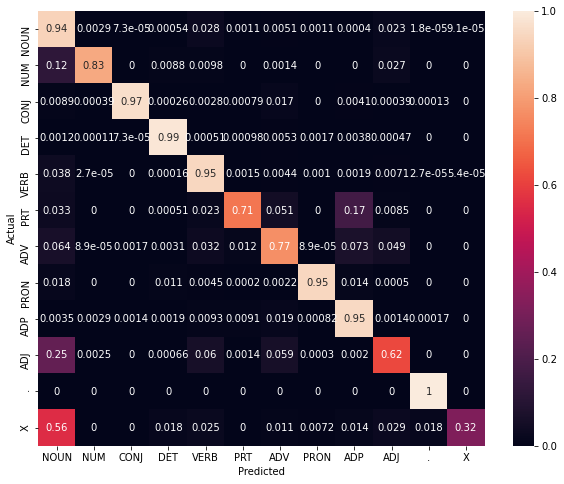

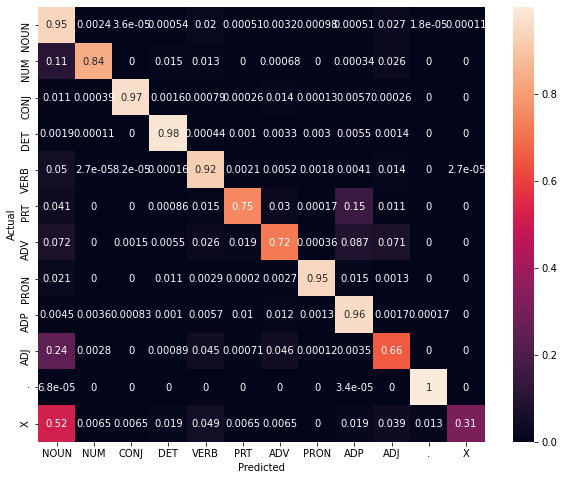

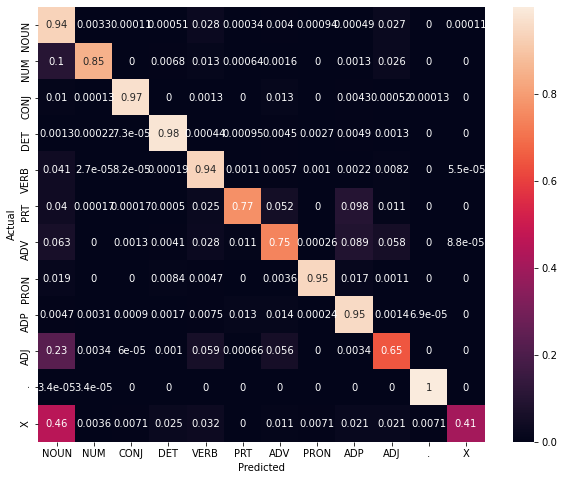

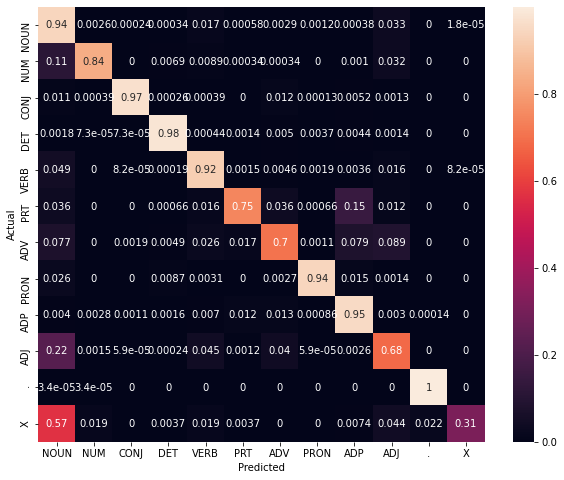

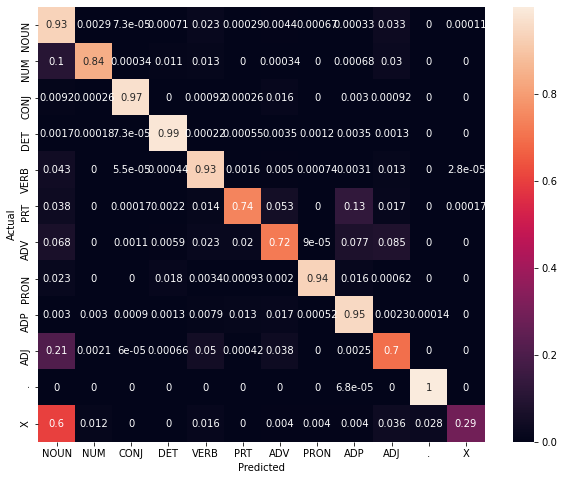

In [25]:

for cm in confusions:  
    for i in range(12):
        s=sum(cm[i])
        for k in range(12):
            cm[i][k]=cm[i][k]/s
    cm_df = pd.DataFrame(cm,tags_plot,tags_plot)            
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.figure(figsize=(10,8))  
    sns.heatmap(cm_df, annot=True)

In [8]:

# for cm in confusions:  
#     for i in range(12):
#         s=sum(cm[i])
#         for k in range(12):
#             cm[i][k]=cm[i][k]/s
#     cm_df = pd.DataFrame(cm,tags_plot,tags_plot)            
#     cm_df.index.name = 'Actual'
#     cm_df.columns.name = 'Predicted'
#     plt.figure(figsize=(10,8))  
#     sns.heatmap(cm_df, annot=True)

In [ ]:
# import pandas as pd
# import itertools
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(y_test_conf_matrix, y_val_pred_sgd_conf_matrix, labels = tags_plot)
# cm=cm.astype('float')
# for i in range(12):
#     s=sum(cm[i])
#     for k in range(12):
#         cm[i][k]=cm[i][k]/s
# cm_df = pd.DataFrame(cm,tags_plot,tags_plot)            
# cm_df.index.name = 'Actual'
# cm_df.columns.name = 'Predicted'
# plt.figure(figsize=(10,8))  
# sns.heatmap(cm_df, annot=True)